In [1]:
#!pip install matplotlib seaborn


In [2]:
import requests
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List, Dict
from sentence_transformers import SentenceTransformer, util

# Configuration visuelle
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Remplacez par l'URL publique si vous n'êtes pas sur localhost
API_URL = "http://localhost:5000/api/chat" 

print("✅ Bibliothèques prêtes.")

print("🔄 Chargement du modèle d'évaluation...")
embedder = SentenceTransformer('all-MiniLM-L6-v2')
print("✅ Modèle chargé")


c:\Users\Claire\Desktop\A5\LLM\ESILV_A5__PROJET_CHATBOT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Bibliothèques prêtes.
🔄 Chargement du modèle d'évaluation...
✅ Modèle chargé


In [8]:
print("\n" + "=" * 60)
print("SECTION 1: EXEMPLES DE REQUÊTES")
print("=" * 60)

# Dataset de questions de test avec réponses attendues COMPLÈTES
test_queries = [
    {
        "question": "Où se trouve le campus principal ?",
        "expected_answer": "Le campus principal de l'ESILV est situé à Paris La Défense",
        "category": "Localisation"
    },
    {
        "question": "Qui est le directeur de l'esilv ?",
        "expected_answer": "Pascal Pinot est le directeur de l'ESILV",
        "category": "Administration"
    },
    {
        "question": "Quelle est la durée du cursus ingénieur ?",
        "expected_answer": "Le cursus ingénieur à l'ESILV dure 5 ans",
        "category": "Cursus"
    },
    {
        "question": "Existe-t-il un double diplôme ingénieur-manager ?",
        "expected_answer": "Oui, l'ESILV propose un double diplôme ingénieur-manager",
        "category": "Programmes"
    },
    {
        "question": "Y a-t-il un programme en Data Science ?",
        "expected_answer": "Oui, l'ESILV propose une spécialisation en Data Science et Intelligence Artificielle",
        "category": "Programmes"
    },
    {
        "question": "Quels sont les programmes disponibles ?",
        "expected_answer": "L'ESILV propose plusieurs majeures dont Data & IA, FinTech, Mécanique, Energie",
        "category": "Programmes"
    },
    {
        "question": "Y a-t-il des bourses disponibles ?",
        "expected_answer": "Oui, des bourses et aides financières sont disponibles pour les étudiants",
        "category": "Admission"
    },
    {
        "question": "Acceptez-vous les étudiants internationaux ?",
        "expected_answer": "Oui, l'ESILV accueille des étudiants internationaux",
        "category": "Admission"
    },
    {
        "question": "Quelles sont les associations étudiantes ?",
        "expected_answer": "L'ESILV dispose de nombreuses associations étudiantes dont le BDE",
        "category": "Vie Étudiante"
    },
    {
        "question": "Quelles activités sportives sont proposées ?",
        "expected_answer": "L'école propose diverses activités sportives pour les étudiants",
        "category": "Vie Étudiante"
    }
]

robustness_tests = [
    {
        "question": "Ou se trouv le kampus ?",
        "expected_answer": "Le campus principal de l'ESILV est situé à Paris La Défense",
        "category": "Robustesse - Typos"
    },
    {
        "question": "C'est où votre école ?",
        "expected_answer": "Le campus principal de l'ESILV est situé à Paris La Défense",
        "category": "Robustesse - Reformulation"
    }
]

# Tests d'hallucination (questions pièges)
hallucination_tests = [
    {
        "question": "Combien coûte le programme de médecine à l'ESILV ?",
        "expected_answer": "",
        "expected_behavior": "should_refuse",
        "category": "Hallucination Test"
    },
    {
        "question": "Qui est le directeur en 2030 ?",
        "expected_answer": "",
        "expected_behavior": "should_refuse",
        "category": "Hallucination Test"
    }
]

# Combine tous les tests
all_tests = test_queries + robustness_tests + hallucination_tests

print(f"\n📝 Nombre total de tests: {len(all_tests)}")
print(f"  • Questions standards: {len(test_queries)}")
print(f"  • Tests de robustesse: {len(robustness_tests)}")
print(f"  • Tests d'hallucination: {len(hallucination_tests)}")

for i, query in enumerate(all_tests, 1):
    print(f"\n{i}. [{query['category']}] {query['question']}")



SECTION 1: EXEMPLES DE REQUÊTES

📝 Nombre total de tests: 14
  • Questions standards: 10
  • Tests de robustesse: 2
  • Tests d'hallucination: 2

1. [Localisation] Où se trouve le campus principal ?

2. [Administration] Qui est le directeur de l'esilv ?

3. [Cursus] Quelle est la durée du cursus ingénieur ?

4. [Programmes] Existe-t-il un double diplôme ingénieur-manager ?

5. [Programmes] Y a-t-il un programme en Data Science ?

6. [Programmes] Quels sont les programmes disponibles ?

7. [Admission] Y a-t-il des bourses disponibles ?

8. [Admission] Acceptez-vous les étudiants internationaux ?

9. [Vie Étudiante] Quelles sont les associations étudiantes ?

10. [Vie Étudiante] Quelles activités sportives sont proposées ?

11. [Robustesse - Typos] Ou se trouv le kampus ?

12. [Robustesse - Reformulation] C'est où votre école ?

13. [Hallucination Test] Combien coûte le programme de médecine à l'ESILV ?

14. [Hallucination Test] Qui est le directeur en 2030 ?


In [9]:

print("\n" + "=" * 60)
print("SECTION 2: FONCTIONS D'ÉVALUATION")
print("=" * 60)

def query_chatbot(question: str) -> Dict:
    """Envoie une question au chatbot et récupère la réponse"""
    start_time = time.time()
    
    try:
        response = requests.post(
            API_URL,
            json={"message": question},
            headers={"Content-Type": "application/json"},
            timeout=3000
        )
        
        latency = time.time() - start_time
        
        if response.status_code == 200:
            data = response.json()
            print(f"DEBUG - JSON reçu: {data}")
            return {
                "success": True,
                "response": data.get("message", ""),  # ← Changé de "response" à "message"
                "latency": latency,
                "status_code": response.status_code
            }
        else:
            return {
                "success": False,
                "response": "",
                "latency": latency,
                "status_code": response.status_code,
                "error": response.text
            }
    except Exception as e:
        latency = time.time() - start_time
        return {
            "success": False,
            "response": "",
            "latency": latency,
            "error": str(e)
        }

def evaluate_semantic_similarity(response: str, expected_answer: str) -> float:
    """Évalue la similarité sémantique entre réponse et attendu"""
    if not response or not expected_answer:
        return 0.0
    
    emb_response = embedder.encode(response, convert_to_tensor=True)
    emb_expected = embedder.encode(expected_answer, convert_to_tensor=True)
    
    similarity = util.cos_sim(emb_response, emb_expected).item()
    return max(0.0, min(1.0, similarity))

def evaluate_hallucination(response: str, expected_behavior: str) -> bool:
    """Vérifie si le modèle refuse correctement les questions pièges"""
    refusal_keywords = [
        "ne sais pas", "ne possède pas", "ne dispose pas",
        "pas d'information", "ne peux pas", "pas disponible",
        "ne propose pas", "n'existe pas"
    ]
    
    if expected_behavior == "should_refuse":
        response_lower = response.lower()
        return any(keyword in response_lower for keyword in refusal_keywords)
    return True

def evaluate_comprehensive(response: str, expected_answer: str, expected_behavior: str = None) -> Dict:
    """Évaluation complète multi-critères"""
    
    # Test d'hallucination
    if expected_behavior == "should_refuse":
        hallucination_ok = evaluate_hallucination(response, expected_behavior)
        return {
            "semantic": 1.0 if hallucination_ok else 0.0,
            "length": 1.0 if hallucination_ok else 0.0,
            "citation": 0.0,
            "overall": 1.0 if hallucination_ok else 0.0,
            "hallucination_test": hallucination_ok
        }
    
    # 1. Similarité sémantique
    semantic_score = evaluate_semantic_similarity(response, expected_answer)
    
    # 2. Score de longueur (pénalise trop court ou trop long)
    length_score = 1.0
    if len(response) < 20:
        length_score = 0.5
    elif len(response) > 500:
        length_score = 0.8
    
    # 3. Présence de citations
    citation_indicators = ['source', 'document', 'selon', 'd\'après', '[', '(']
    citation_score = 1.0 if any(ind in response.lower() for ind in citation_indicators) else 0.0
    
    # 4. Score global pondéré
    overall_score = (
        semantic_score * 0.7 +
        length_score * 0.2 +
        citation_score * 0.1
    )
    
    return {
        "semantic": semantic_score,
        "length": length_score,
        "citation": citation_score,
        "overall": overall_score,
        "hallucination_test": True
    }



SECTION 2: FONCTIONS D'ÉVALUATION


In [10]:

print("\n" + "=" * 60)
print("SECTION 3: EXÉCUTION DES TESTS")
print("=" * 60)

results = []

print("\n🔄 Exécution des tests en cours...\n")

for i, test in enumerate(all_tests, 1):
    print(f"Test {i}/{len(all_tests)}: {test['question'][:50]}...")
    
    # Requête au chatbot
    result = query_chatbot(test['question'])
    
    # Évaluation
    scores = evaluate_comprehensive(
        result['response'], 
        test['expected_answer'],
        test.get('expected_behavior', None)
    )
    
    # Debug : afficher réponse
    print(f"  📄 Réponse: {result['response'][:100]}...")
    print(f"  📊 Scores: Sémantique={scores['semantic']:.2f} | Overall={scores['overall']:.2f}")
    print(f"  ⏱️  Latence: {result['latency']:.2f}s\n")
    
    results.append({
        "question": test['question'],
        "category": test['category'],
        "response": result['response'],
        "expected_answer": test['expected_answer'],
        "latency": result['latency'],
        "semantic": scores['semantic'],
        "length": scores['length'],
        "citation": scores['citation'],
        "overall": scores['overall'],
        "success": result['success'],
        "hallucination_ok": scores.get('hallucination_test', True)
    })

# Création du DataFrame
df_results = pd.DataFrame(results)



SECTION 3: EXÉCUTION DES TESTS

🔄 Exécution des tests en cours...

Test 1/14: Où se trouve le campus principal ?...
DEBUG - JSON reçu: {'is_form': False, 'message': "Le campus principal de l'ESILV est situé à Paris-La Défense.", 'session_id': 'b5e56b51-2f7b-4530-a93e-ee151d3e2fbb', 'suggestions': ['Où se trouve le campus principal ?', 'Je souhaite être contacté', 'Quelles sont les associations étudiantes ?', 'Quelle est la durée du cursus ingénieur ?'], 'timestamp': '2025-12-23T09:51:12.232219'}
  📄 Réponse: Le campus principal de l'ESILV est situé à Paris-La Défense....
  📊 Scores: Sémantique=0.99 | Overall=0.89
  ⏱️  Latence: 163.55s

Test 2/14: Qui est le directeur de l'esilv ?...
DEBUG - JSON reçu: {'is_form': False, 'message': "Le directeur de l'ESILV est Pascal Pinot.", 'session_id': '4b7d4e50-b092-4e63-a80e-4970570d755d', 'suggestions': ['Où se trouve le campus principal ?', 'Je souhaite être contacté', 'Quelles sont les associations étudiantes ?', 'Quelle est la durée du cursu

In [12]:

print("\n" + "=" * 60)
print("SECTION 4: RÉSULTATS GLOBAUX")
print("=" * 60)

# Statistiques générales
print(f"\n📊 STATISTIQUES GLOBALES:")
print(f"  • Tests réussis: {df_results['success'].sum()}/{len(df_results)} ({df_results['success'].mean():.1%})")
print(f"  • Score sémantique moyen: {df_results['semantic'].mean():.1%}")
print(f"  • Score global moyen: {df_results['overall'].mean():.1%}")
print(f"  • Latence moyenne: {df_results['latency'].mean():.2f}s")
print(f"  • Latence médiane: {df_results['latency'].median():.2f}s")
print(f"  • Latence min: {df_results['latency'].min():.2f}s")
print(f"  • Latence max: {df_results['latency'].max():.2f}s")

# Tests d'hallucination
hallucination_results = df_results[df_results['category'].str.contains('Hallucination')]
if not hallucination_results.empty:
    hallucination_rate = hallucination_results['hallucination_ok'].mean()
    print(f"  • Taux de refus correct (hallucination): {hallucination_rate:.1%}")

# Statistiques par catégorie
print(f"\n📈 PERFORMANCE PAR CATÉGORIE:")
category_stats = df_results.groupby('category').agg({
    'overall': 'mean',
    'semantic': 'mean',
    'latency': 'mean'
}).round(3)
print(category_stats)

# Détection d'outliers de latence
Q1 = df_results['latency'].quantile(0.25)
Q3 = df_results['latency'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_results[
    (df_results['latency'] < Q1 - 1.5 * IQR) | 
    (df_results['latency'] > Q3 + 1.5 * IQR)
]

if not outliers.empty:
    print(f"\n⚠️  {len(outliers)} questions avec latence anormale:")
    for _, row in outliers.iterrows():
        print(f"  • {row['question'][:60]}... → {row['latency']:.2f}s")


SECTION 4: RÉSULTATS GLOBAUX

📊 STATISTIQUES GLOBALES:
  • Tests réussis: 14/14 (100.0%)
  • Score sémantique moyen: 64.8%
  • Score global moyen: 64.9%
  • Latence moyenne: 149.36s
  • Latence médiane: 160.73s
  • Latence min: 48.55s
  • Latence max: 229.37s
  • Taux de refus correct (hallucination): 0.0%

📈 PERFORMANCE PAR CATÉGORIE:
                            overall  semantic  latency
category                                              
Administration                0.888     0.983  163.308
Admission                     0.772     0.775  184.206
Cursus                        0.777     0.825  188.454
Hallucination Test            0.000     0.000  165.371
Localisation                  0.892     0.988  163.548
Programmes                    0.746     0.704  147.651
Robustesse - Reformulation    0.607     0.581   48.554
Robustesse - Typos            0.712     0.732   49.085
Vie Étudiante                 0.717     0.653  168.014

⚠️  3 questions avec latence anormale:
  • Y a-t-il des

In [13]:
# Ajoute cette analyse après les tests
latency_by_category = df_results.groupby('category').agg({
    'latency': ['mean', 'std', 'min', 'max'],
    'overall': 'mean'
}).round(2)

print("\n📊 LATENCE ET PERFORMANCE PAR CATÉGORIE:")
print(latency_by_category)

# Détecte les outliers de latence
Q1 = df_results['latency'].quantile(0.25)
Q3 = df_results['latency'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_results[
    (df_results['latency'] < Q1 - 1.5 * IQR) | 
    (df_results['latency'] > Q3 + 1.5 * IQR)
]

if not outliers.empty:
    print(f"\n⚠️  {len(outliers)} questions avec latence anormale:")
    for _, row in outliers.iterrows():
        print(f"  • {row['question'][:50]}... → {row['latency']:.2f}s")


📊 LATENCE ET PERFORMANCE PAR CATÉGORIE:
                           latency                        overall
                              mean    std     min     max    mean
category                                                         
Administration              163.31    NaN  163.31  163.31    0.89
Admission                   184.21  63.86  139.05  229.37    0.77
Cursus                      188.45    NaN  188.45  188.45    0.78
Hallucination Test          165.37  10.21  158.16  172.59    0.00
Localisation                163.55    NaN  163.55  163.55    0.89
Programmes                  147.65  20.40  125.93  166.40    0.75
Robustesse - Reformulation   48.55    NaN   48.55   48.55    0.61
Robustesse - Typos           49.08    NaN   49.08   49.08    0.71
Vie Étudiante               168.01  24.17  150.92  185.10    0.72

⚠️  3 questions avec latence anormale:
  • Y a-t-il des bourses disponibles ?... → 229.37s
  • Ou se trouv le kampus ?... → 49.08s
  • C'est où votre école ?... → 48.


SECTION 5: VISUALISATIONS


C:\Users\Claire\AppData\Local\Temp\ipykernel_4356\1364661935.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([metrics_data['semantic'], metrics_data['length'],



✅ Graphiques sauvegardés: evaluation_results_advanced.png


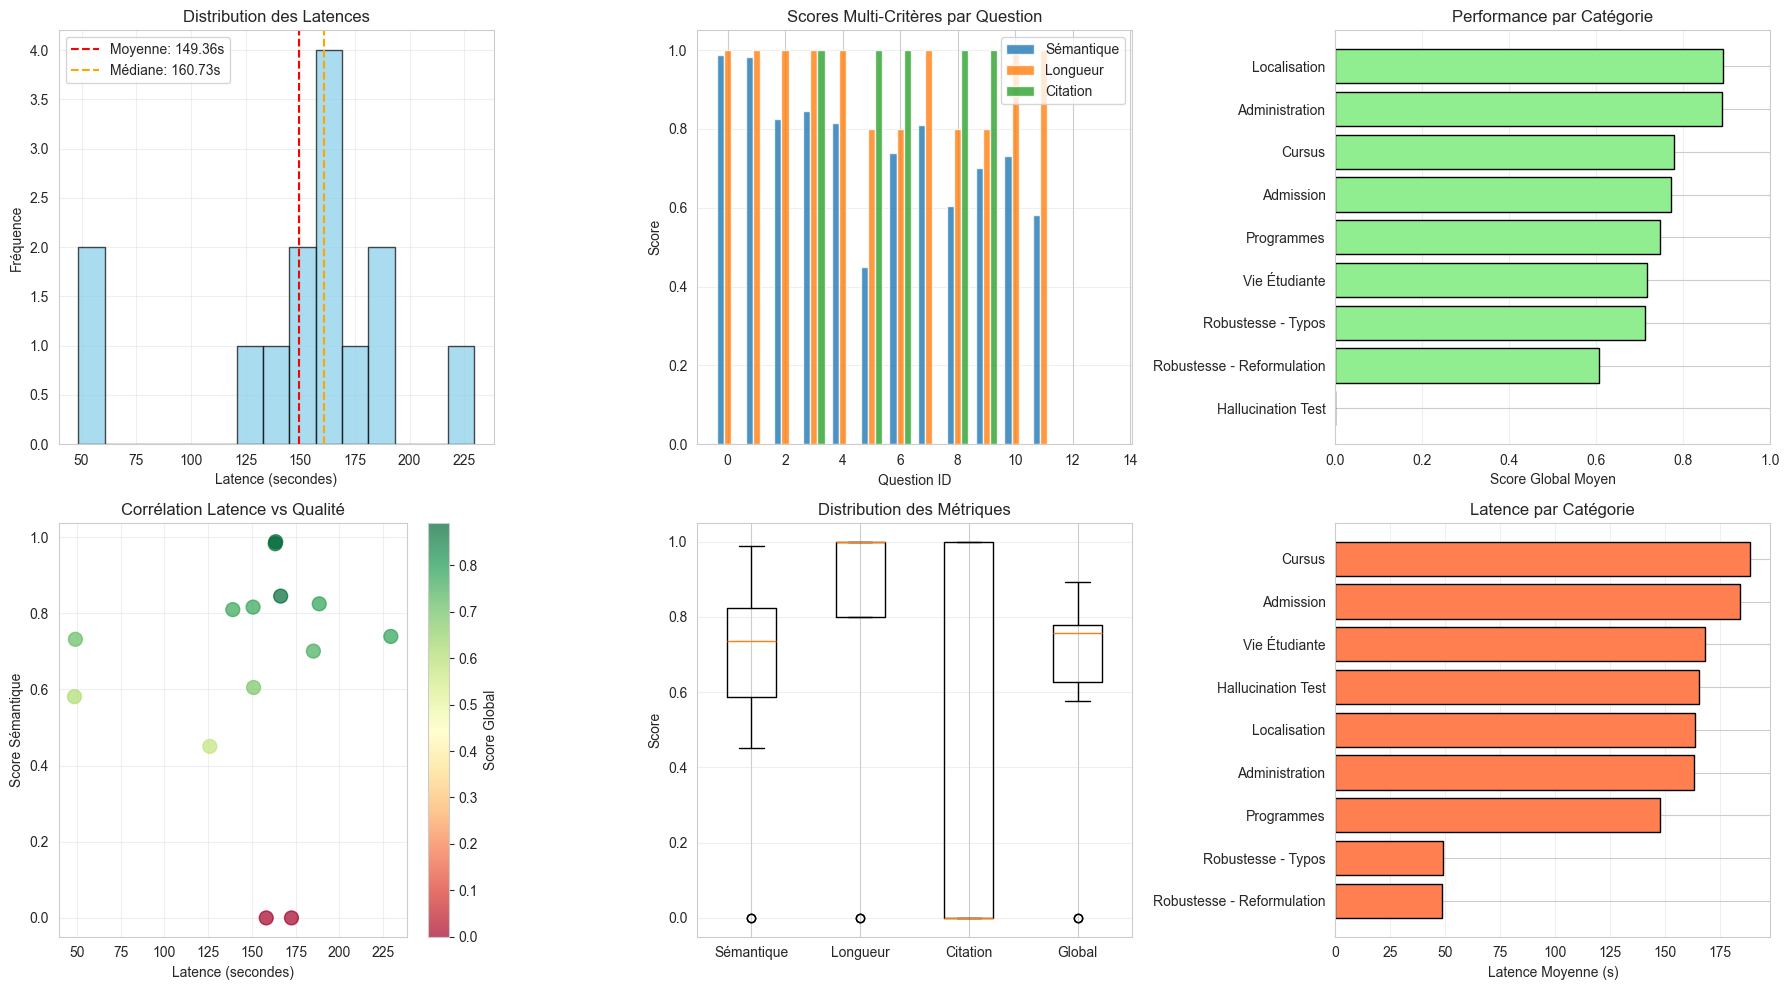

In [14]:

print("\n" + "=" * 60)
print("SECTION 5: VISUALISATIONS")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Graphique 1: Distribution des latences
axes[0, 0].hist(df_results['latency'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_results['latency'].mean(), color='red', linestyle='--', 
                   label=f'Moyenne: {df_results["latency"].mean():.2f}s')
axes[0, 0].axvline(df_results['latency'].median(), color='orange', linestyle='--',
                   label=f'Médiane: {df_results["latency"].median():.2f}s')
axes[0, 0].set_xlabel('Latence (secondes)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution des Latences')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Graphique 2: Scores multiples par question
x_pos = np.arange(len(df_results))
width = 0.25
axes[0, 1].bar(x_pos - width, df_results['semantic'], width, label='Sémantique', alpha=0.8)
axes[0, 1].bar(x_pos, df_results['length'], width, label='Longueur', alpha=0.8)
axes[0, 1].bar(x_pos + width, df_results['citation'], width, label='Citation', alpha=0.8)
axes[0, 1].set_xlabel('Question ID')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Scores Multi-Critères par Question')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Graphique 3: Performance par catégorie
category_scores = df_results.groupby('category')['overall'].mean().sort_values()
axes[0, 2].barh(category_scores.index, category_scores.values, color='lightgreen', edgecolor='black')
axes[0, 2].set_xlabel('Score Global Moyen')
axes[0, 2].set_title('Performance par Catégorie')
axes[0, 2].set_xlim([0, 1])
axes[0, 2].grid(True, alpha=0.3, axis='x')

# Graphique 4: Latence vs Score Sémantique
scatter = axes[1, 0].scatter(df_results['latency'], df_results['semantic'], 
                            c=df_results['overall'], cmap='RdYlGn', s=100, alpha=0.7)
axes[1, 0].set_xlabel('Latence (secondes)')
axes[1, 0].set_ylabel('Score Sémantique')
axes[1, 0].set_title('Corrélation Latence vs Qualité')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Score Global')

# Graphique 5: Boxplot des métriques
metrics_data = df_results[['semantic', 'length', 'citation', 'overall']]
axes[1, 1].boxplot([metrics_data['semantic'], metrics_data['length'], 
                     metrics_data['citation'], metrics_data['overall']],
                    labels=['Sémantique', 'Longueur', 'Citation', 'Global'])
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Distribution des Métriques')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Graphique 6: Latence par catégorie
category_latency = df_results.groupby('category')['latency'].mean().sort_values()
axes[1, 2].barh(category_latency.index, category_latency.values, color='coral', edgecolor='black')
axes[1, 2].set_xlabel('Latence Moyenne (s)')
axes[1, 2].set_title('Latence par Catégorie')
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('evaluation_results_advanced.png', dpi=300, bbox_inches='tight')
print("\n✅ Graphiques sauvegardés: evaluation_results_advanced.png")
plt.show()

In [15]:

print("\n" + "=" * 60)
print("SECTION 6: EXPORT DES RÉSULTATS")
print("=" * 60)

# Export CSV
df_results.to_csv('evaluation_results.csv', index=False, encoding='utf-8')
print("✅ Résultats CSV: evaluation_results.csv")

# Export JSON détaillé
detailed_results = {
    "metadata": {
        "date": time.strftime("%Y-%m-%d %H:%M:%S"),
        "total_queries": len(all_tests),
        "model": "gemma2:2b",
        "evaluator": "sentence-transformers/all-MiniLM-L6-v2"
    },
    "summary": {
        "success_rate": float(df_results['success'].mean()),
        "avg_semantic_score": float(df_results['semantic'].mean()),
        "avg_overall_score": float(df_results['overall'].mean()),
        "avg_latency": float(df_results['latency'].mean()),
        "median_latency": float(df_results['latency'].median()),
        "hallucination_prevention": float(hallucination_results['hallucination_ok'].mean()) if not hallucination_results.empty else None
    },
    "by_category": category_stats.to_dict(),
    "detailed_results": results
}

with open('evaluation_results.json', 'w', encoding='utf-8') as f:
    json.dump(detailed_results, f, indent=2, ensure_ascii=False)
print("✅ Résultats JSON: evaluation_results.json")

# ===============================================
# 7. RECOMMANDATIONS
# ===============================================

print("\n" + "=" * 60)
print("SECTION 7: RECOMMANDATIONS")
print("=" * 60)

recommendations = []

if df_results['latency'].mean() > 60:
    recommendations.append("⚠️  Latence très élevée (>60s). Priorité : optimisation avec GPU ou modèles quantifiés.")

if df_results['latency'].mean() > 10:
    recommendations.append("⚠️  Latence élevée. Envisager GGUF quantization ou passage à GPU.")
    
if df_results['semantic'].mean() < 0.6:
    recommendations.append("⚠️  Score sémantique faible (<60%). Améliorer la qualité du RAG (chunking, reranking).")
    
if df_results['overall'].mean() < 0.65:
    recommendations.append("⚠️  Score global faible. Revoir la qualité des documents sources et les prompts.")
    
if df_results['success'].mean() < 0.95:
    recommendations.append("⚠️  Taux d'échec élevé. Vérifier la stabilité de l'API et d'Ollama.")

if not hallucination_results.empty and hallucination_results['hallucination_ok'].mean() < 0.8:
    recommendations.append("⚠️  Le modèle hallucine sur questions pièges. Améliorer les prompts système.")

if df_results['citation'].mean() < 0.3:
    recommendations.append("ℹ️  Peu de citations détectées. Envisager d'ajouter des sources dans les réponses.")

if recommendations:
    print("\n📌 POINTS D'AMÉLIORATION:")
    for rec in recommendations:
        print(f"  {rec}")
else:
    print("\n✅ Performances satisfaisantes ! Aucune amélioration critique nécessaire.")

# Meilleures et pires performances
print("\n🏆 TOP 3 MEILLEURES PERFORMANCES:")
top_3 = df_results.nlargest(3, 'overall')[['question', 'overall', 'latency']]
for idx, row in top_3.iterrows():
    print(f"  • {row['question'][:60]}... → Score: {row['overall']:.2%}, Latence: {row['latency']:.2f}s")

print("\n⚠️  TOP 3 PIRES PERFORMANCES:")
bottom_3 = df_results.nsmallest(3, 'overall')[['question', 'overall', 'latency']]
for idx, row in bottom_3.iterrows():
    print(f"  • {row['question'][:60]}... → Score: {row['overall']:.2%}, Latence: {row['latency']:.2f}s")

print("\n" + "=" * 60)
print("ÉVALUATION TERMINÉE ✅")
print("=" * 60)
print("\n📂 Fichiers générés:")
print("  • evaluation_results.csv")
print("  • evaluation_results.json")
print("  • evaluation_results_advanced.png")


SECTION 6: EXPORT DES RÉSULTATS
✅ Résultats CSV: evaluation_results.csv
✅ Résultats JSON: evaluation_results.json

SECTION 7: RECOMMANDATIONS

📌 POINTS D'AMÉLIORATION:
  ⚠️  Latence très élevée (>60s). Priorité : optimisation avec GPU ou modèles quantifiés.
  ⚠️  Latence élevée. Envisager GGUF quantization ou passage à GPU.
  ⚠️  Score global faible. Revoir la qualité des documents sources et les prompts.
  ⚠️  Le modèle hallucine sur questions pièges. Améliorer les prompts système.

🏆 TOP 3 MEILLEURES PERFORMANCES:
  • Où se trouve le campus principal ?... → Score: 89.16%, Latence: 163.55s
  • Existe-t-il un double diplôme ingénieur-manager ?... → Score: 89.16%, Latence: 166.40s
  • Qui est le directeur de l'esilv ?... → Score: 88.79%, Latence: 163.31s

⚠️  TOP 3 PIRES PERFORMANCES:
  • Combien coûte le programme de médecine à l'ESILV ?... → Score: 0.00%, Latence: 172.59s
  • Qui est le directeur en 2030 ?... → Score: 0.00%, Latence: 158.16s
  • Quels sont les programmes disponibles 